In [1]:
import importlib
import datetime
import mapplotting
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import cartopy
import pandas
import xarray
import matplotlib
from GliderTools import glidertools as gt
import matplotlib.dates as mdates
import string
import dictionaries
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple

pdates = [np.datetime64('2022-10-06'), 
          np.datetime64('2022-10-15'),
          np.datetime64('2022-10-30'),
          np.datetime64('2022-11-16'),
          np.datetime64('2022-12-01'),
          np.datetime64('2022-12-15'),
          np.datetime64('2022-12-30')]

from download_glider_data import utils
from GliderTools import glidertools as gt

dataset_ids = dictionaries.timelines['NS_methane_sensor'][:]
dataset_ids = ['nrt_'+dataset_id for dataset_id in dataset_ids]
datasets_dict = utils.download_glider_dataset(dataset_ids, 
        )
datasets_list = [gt.load.voto_seaexplorer_dataset(ds) for ds in [*datasets_dict.values()]]
dsg = gt.load.voto_concat_datasets(datasets_list)

def create_1a(fig, ax):
    import matplotlib.patheffects as pe
    import cartopy.feature as cfeature
    import geopandas as gp
    import cartopy.crs as ccrs
    
    def create_map_figure(fig, ax, zoomin=True, cbar=False):
        pc, ax, gl = mapplotting.plot_concentrations_map(fig, ax, bathy=True, 
                                                         zoomin=zoomin, 
                                                         cbar=False,
                                                         gtrajectory=True,
                                                         biglabels=False)
        return fig, ax, pc, gl

    importlib.reload(mapplotting)
    df_helcom = gp.read_file("../data/input/_ags_HELCOM_subbasins_2022_level21/HELCOM_subbasins_2022_level2.shp")
    secondround = dict(showmodel=True, zoomin=False)

    fig, ax, pc, gl = create_map_figure(fig, ax, zoomin=False)
    gl.xlabels_top = True
    gl.xlabels_bottom = False
    gl.xlabel_style = {'color':'k', 'rotation':0}

    mapplotting.plot_helcom(ax, df_helcom)
    mapplotting.plot_pipelines(ax)
    
    df_ferry = pandas.read_csv(
    '../data/input/IOW_Ferry_box/IOW_SOOP_Finnmaid_CH4_data_Rehder_Bittig_Glockzin_for_VOTO/'
    'IOW_SOOP_Finnmaid_CH4_data_Rehder_Bittig_Glockzin_for_DLR.txt')
    df_ferry['time'] = pandas.to_datetime(df_ferry['MatlabTime']-719529, unit='D')
    df_ferry = df_ferry.dropna()
    ax.plot(df_ferry.Lon[6000:8000], 
            df_ferry.Lat[6000:8000], 
            transform=ccrs.PlateCarree(),
            color='red')

    vmin=1e-9
    vmax=1e-5

    legend_elements = [Line2D([0], [0], color='w', ls='-', 
                      path_effects=[pe.Stroke(linewidth=5, foreground='k'), pe.Normal()],
                      lw=2, label='Glider observation transect'),
                      Line2D([0], [0], marker='X', color='w',
                        markerfacecolor='orange', markersize=10, label='Methane leak location'),
                      Line2D([0], [0], color='lightgrey', 
                             lw=4, label='Nordstream pipeline (approx)'),
                    Line2D([0], [0], color='red', 
                             lw=1.5, label='SPOOP transect'),]
    ax.legend(handles=legend_elements, loc='upper left', framealpha=1.,
              fontsize=11, handlelength=1.5).set_zorder(100)
    return ax


https://erddap.observations.voiceoftheocean.org/erddap/tabledap/nrt_SEA070_M13.html?
https://erddap.observations.voiceoftheocean.org/erddap/tabledap/nrt_SEA070_M14.html?
https://erddap.observations.voiceoftheocean.org/erddap/tabledap/nrt_SEA070_M15.html?
https://erddap.observations.voiceoftheocean.org/erddap/tabledap/nrt_SEA056_M54.html?
https://erddap.observations.voiceoftheocean.org/erddap/tabledap/nrt_SEA056_M55.html?
https://erddap.observations.voiceoftheocean.org/erddap/tabledap/nrt_SEA056_M56.html?
https://erddap.observations.voiceoftheocean.org/erddap/tabledap/nrt_SEA056_M57.html?


In [2]:
# load Ferry box data in nmol/l
def create_1b(fig, ax):
    vmin=1e-9
    vmax=1e-5
    df_ferry = pandas.read_csv(
        '../data/input/IOW_Ferry_box/IOW_SOOP_Finnmaid_CH4_data_Rehder_Bittig_Glockzin_for_VOTO/'
        'IOW_SOOP_Finnmaid_CH4_data_Rehder_Bittig_Glockzin_for_DLR.txt')
    df_ferry['time'] = pandas.to_datetime(df_ferry['MatlabTime']-719529, unit='D')
    df_ferry = df_ferry.dropna()
    df_ferry.drop(['MatlabTime', 'ExcelTime', 'Day', 'Month', 'Year', 'Hour', 'Minute'], axis=1)
    df_ferry = df_ferry[(df_ferry.Lon>14) & (df_ferry.Lon<18)]
    df_ferry[['Lon', 'cCH4is_nmol_l_corr', 'time']]
    cc = ax.scatter(df_ferry.time, df_ferry.Lon, c=df_ferry.cCH4is_nmol_l_corr*1e-9, s=15,
                norm=matplotlib.colors.LogNorm(
                            vmin=vmin,
                            vmax=vmax,
                ),
                cmap=matplotlib.cm.Reds,
           )
    
    ax.set_ylabel('Longitude ⁰E')
    cb = plt.colorbar(cc, pad=0.02, ax=ax, fraction=0.05, label='Methane Conc. [mol l⁻¹]')
    
    # Change date format
    datefmt = mdates.DateFormatter('%Y-%b')
    ax.xaxis.set_major_formatter(datefmt)

    # Set the Major locator for x-axis to month Jan and August
    # and minor locator as month between these major locators
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_locator(mdates.DayLocator(bymonthday=15))
    
    ax.scatter(dsg.time, dsg.longitude, color='k', s=1)
    legend_elements = [Line2D([0], [0], color='k', 
                             lw=1.5, label='Glider longitude')]
    ax.legend(handles=legend_elements, loc='upper right', framealpha=1.,
              fontsize=12, handlelength=1.5).set_zorder(100)
    
    return fig, ax


In [3]:
def create_1d(fig, ax):
    vmin = 5e-9
    vmax = 5e-6
    ds = xarray.open_mfdataset('../data/input/methane_processed_bastien/timeseries_output.nc')
    ds['meantime'] = gt.utils.time_average_per_dive(ds.profile_num, ds.time)
    dsud = ds.where(ds.profile_num.values%2==1)
    ax = gt.plot(dsud.meantime, 
            dsud.depth, 
            dsud.methane*1e-6, 
            norm=matplotlib.colors.LogNorm(
                                vmin=vmin,
                                vmax=vmax
                      ),
            cmap=matplotlib.cm.Reds,
            ax=ax,
            robust=False,)
    
    ax.cb.set_label('Methane conc [mol l⁻¹]')
    for mydate in pdates:
        ax.scatter(x=mydate, y=ax.get_ylim()[0], marker="^",  s=500,)
    
    [tick.set_rotation(0) for tick in ax.get_xticklabels()]
    
    # now load and plot the mld and lcline
    dfmld = pandas.read_csv('rf_mld.csv', parse_dates=True)
    dfmld['time'] = pandas.to_datetime(dfmld.time)
    dflcline = pandas.read_csv('rf_lcline.csv')
    dflcline['time'] = pandas.to_datetime(dflcline.time)
    dftcline = pandas.read_csv('rf_tcline.csv')
    dftcline['time'] = pandas.to_datetime(dftcline.time)

    ax.plot(dftcline.time, 
            dftcline.tcline.rolling(window=10, center=True).mean(), 
            color='darkred', 
            label='thermocline',
            lw=1)
    ax.plot(dflcline.time, 
            dflcline.lcline.rolling(window=10, center=True).mean(), 
            color='tab:blue', 
            label='halocline',
            lw=1)

    ax.legend(loc='upper right')
    return fig, ax

In [4]:
def create_1c(fig, ax):
    ds = xarray.open_mfdataset('../data/input/methane_processed_bastien/timeseries_output.nc')
    ds['meantime'] = gt.utils.time_average_per_dive(ds.profile_num, ds.time)
    dsud = ds.where(ds.profile_num.values%2==1).dropna(dim='time', subset=['depth'])
    dfud = dsud.to_pandas()
    df_ferry = pandas.read_csv(
        '../data/input/IOW_Ferry_box/IOW_SOOP_Finnmaid_CH4_data_Rehder_Bittig_Glockzin_for_VOTO/'
        'IOW_SOOP_Finnmaid_CH4_data_Rehder_Bittig_Glockzin_for_DLR.txt')
    df_ferry['time'] = pandas.to_datetime(df_ferry['MatlabTime']-719529, unit='D')
    df_ferry_groups = df_ferry.groupby(df_ferry.time.dt.date).max()

    p = dsud.sel(time=pdates, method='nearest')
    pnumbers = p.profile_num.values
    labeltupels = []
    for index, pnumber in enumerate(pnumbers):
        dfp = dfud[dfud.profile_num==pnumber]
        label_glprofile, = ax.plot(dfp.methane*1e-6, -dfp.depth, label=dfp.index.date[0])
        
        x = df_ferry_groups.to_xarray().sel(
            time=pdates[index], method='nearest').cCH4is_nmol_l_corr/1e9
        label_surfaceferry = ax.scatter(x, 0)
        labeltupels.append((label_glprofile, label_surfaceferry))
    ax.set_xlim(1e-9, None)
    ax.set_ylabel('Depth [m]')
    ax.set_xscale('log')
    ax.grid()
    
    l = ax.legend(labeltupels, pdates, numpoints=1,
              handler_map={tuple: HandlerTuple(ndivide=None)},
              loc='upper left', fontsize=10, title='Glider, SPOOP',
              title_fontsize=10)


/media/coffee/T7/Nordstream/code/GliderTools/glidertools/helpers.py:97: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  xds = xr.DataArray(
/media/coffee/T7/Nordstream/code/GliderTools/glidertools/helpers.py:97: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be

Found tiles [PosixPath('/home/coffee/VOTO/data/bathymetry/emodnet_baltic/D5_2020.nc'), PosixPath('/home/coffee/VOTO/data/bathymetry/emodnet_baltic/C7_2020.nc'), PosixPath('/home/coffee/VOTO/data/bathymetry/emodnet_baltic/D6_2020.nc'), PosixPath('/home/coffee/VOTO/data/bathymetry/emodnet_baltic/C5_2020.nc'), PosixPath('/home/coffee/VOTO/data/bathymetry/emodnet_baltic/C6_2020.nc'), PosixPath('/home/coffee/VOTO/data/bathymetry/emodnet_baltic/D7_2020.nc')]
Found 2 tiles with relevant data: [PosixPath('/home/coffee/VOTO/data/bathymetry/emodnet_baltic/D5_2020.nc'), PosixPath('/home/coffee/VOTO/data/bathymetry/emodnet_baltic/D6_2020.nc')]
data in one row, patching lon


/home/coffee/micromamba/envs/analysis/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/coffee/micromamba/envs/analysis/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '


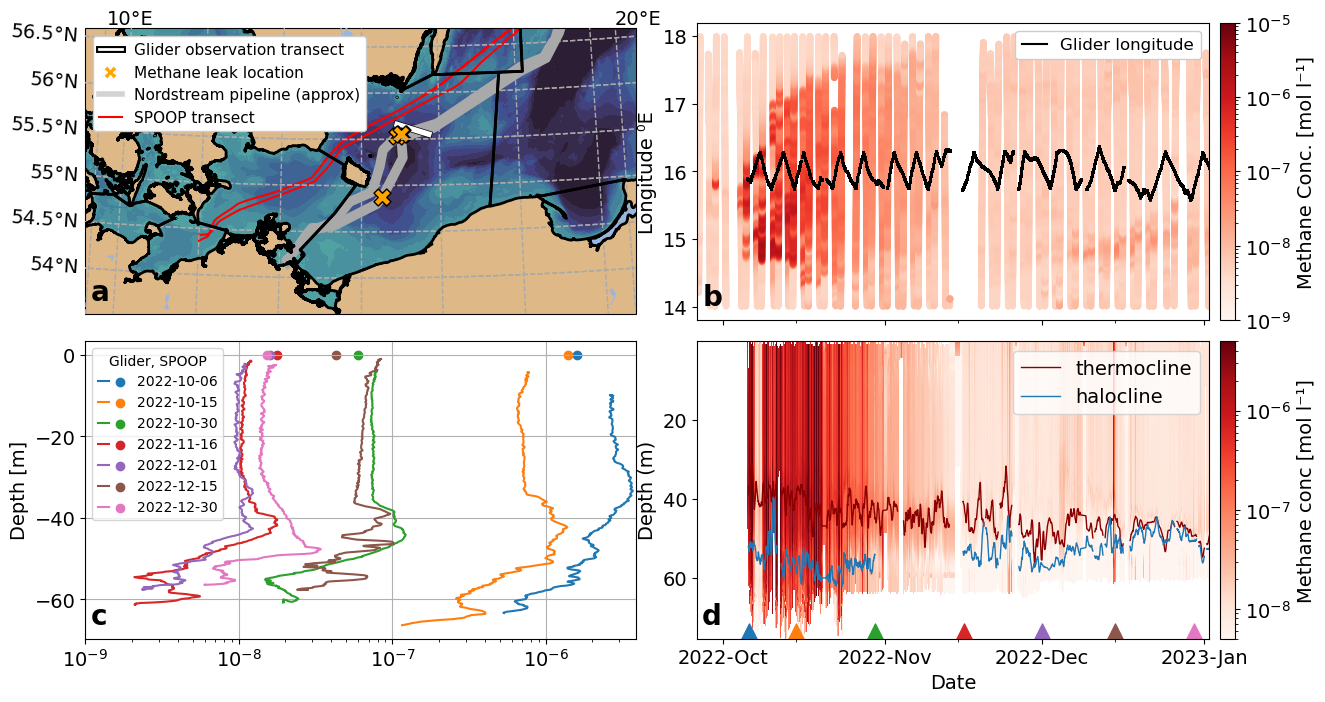

In [6]:
S_lim = 53.5
N_lim = 60
W_lim = 10
E_lim = 20
pc = cartopy.crs.PlateCarree()
coord = cartopy.crs.AzimuthalEquidistant(central_longitude=np.mean((W_lim, E_lim)),
                                  central_latitude=np.mean((S_lim, N_lim)))

plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=[15,8])
gs = fig.add_gridspec(nrows=10, ncols=10, hspace=0.5, wspace=1)
ax0 = fig.add_subplot(gs[0:5,0:5], projection=coord)
ax3 = fig.add_subplot(gs[5:,5:10])
ax1 = fig.add_subplot(gs[0:5,5:], sharex=ax3)
ax2 = fig.add_subplot(gs[5:,0:5])

plt.setp(ax1.get_xticklabels(), visible=False)

create_1b(fig, ax1)
create_1c(fig, ax2)
create_1d(fig, ax3)

ax1.set_xlabel(None)
ax3.set_xlim(np.datetime64('2022-09-26'), np.datetime64('2023-01-02'))
ax0 = create_1a(fig, ax0)

for n, ax in enumerate([ax0, ax1, ax2, ax3]):
    ax.text(0.01, 0.05, string.ascii_lowercase[n], transform=ax.transAxes, 
            size=20, weight='bold', zorder=100)

plt.savefig('../figures/rf_Figure1.png', transparent=True)